# MultistageOT applied to a single-cell RNA-sequencing snapshot of hematopoiesis

In this notebook, we apply MultistageOT to the data from Paul et al. (2015).

In [39]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sbn 

sys.path.append("../../../../")

from packages.models.multistageot import MultistageOT
import packages.models.tools as tools

In [40]:
sc.__version__

'1.9.3'

In [41]:
################# Define paths: ################# 
DATA_PATH    = "../../../../data/real/paul2015/"
RESULTS_PATH = "../../../../results/real_data/paul2015/"
MODEL_PATH   = RESULTS_PATH + "saved_models/"

### Load data and perform a simple preprocessing step

In [42]:
adata = sc.datasets.paul15()
adata.X = adata.X.astype("float64")

#Save a .csv:
#pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names).to_csv(DATA_PATH + "paul2015.csv") 

adata_all_genes = adata.copy() 
sc.pp.recipe_zheng17(adata)

/Users/magnus/.conda/envs/manuscript_1/lib/python3.9/site-packages/scanpy/datasets/_datasets.py:202: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = 840


### Compute a UMAP

In [43]:
sc.tl.pca(adata, svd_solver="arpack")

In [44]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

In [45]:
sc.tl.umap(adata, random_state=123)

Flip a UMAP coordinate (this simply mirrors the UMAP in the y-axis to make it more familiar in relation to the data in Dahlin 2018):

In [46]:
adata.obsm['X_umap'][:,1] = -adata.obsm['X_umap'][:,1]


/Users/magnus/.conda/envs/manuscript_1/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


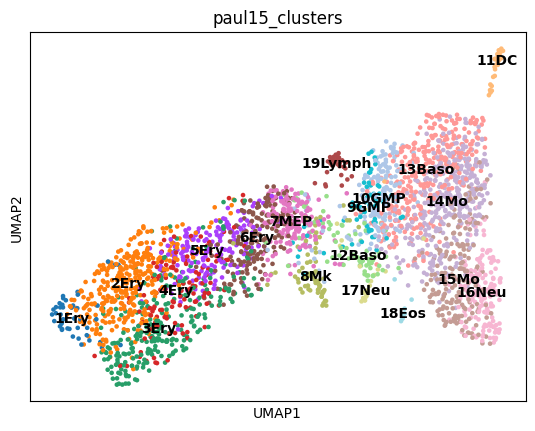

In [47]:
sc.pl.umap(adata, color="paul15_clusters", legend_loc="on data")

Extract the UMAP embedding coordinates to a separate DataFrame:

In [48]:
embedding = pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index,columns=['umap_1','umap_2'])

Define colors and lineage-associated marker genes for each mature cell type:

In [49]:
cell_types = ['Monocyte',
            'Lymphoid',
            'Meg',
            'Neutrophil',
            'Eos',
            'Baso',
            'Mast',
            'Erythroid', 'HSC']
 
gene_list = ['Ly86','Dntt','Pf4','Elane','Prg3','Prss34','Gzmb','Klf1','Mpl']

colors = np.array([[0,	111, 252], 
               [145, 254, 70],
               [30, 191, 193], 
               [208, 4, 38],
               [85, 50, 5],
               [254, 168, 64],
               [26, 136, 19],
               [251, 87, 252], [0,0,0]]) 

colors = colors/255

cell_type_colors = { cell_types[i] : colors[i] for i in range(len(cell_types)) }
lineage_associated_genes = { cell_types[i] : gene_list[i] for i in range(len(cell_types)) }


### Plotting lineage-associated gene markers

We graph a layered representation of all lineage-associated markers:

([], [])

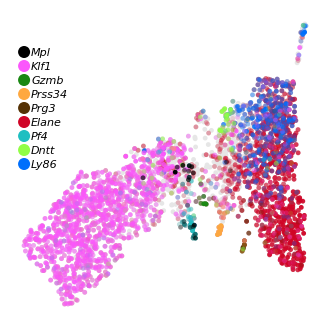

In [50]:
import matplotlib.font_manager as font_manager

font = font_manager.FontProperties(style='italic')

fig, ax = plt.subplots(figsize=(4,4))

annotation_colors = np.concatenate((colors, np.array([[0.1,0.1,0.1]])),axis=0)

zorder = [3,9,10,1,4,8,11,7,12]

data_z_scores = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names)
data_z_scores = (data_z_scores - data_z_scores.mean()) / data_z_scores.std()

#Normalize embedding to unit square:
embedding_normalized = (embedding - embedding.min()) / (embedding.max() - embedding.min())

ax.scatter(embedding_normalized['umap_1'],embedding_normalized['umap_2'], facecolor=[0.9,0.9,0.9], edgecolor='none',s = 12,zorder=0) 

for i in range(len(gene_list)):
    
    gene_exp = data_z_scores[gene_list[i]]
    plot_order = gene_exp.sort_values(ascending=True).index
    gene_exp_sorted = gene_exp.loc[plot_order]
    
    alpha = (gene_exp_sorted - np.min(gene_exp_sorted) ) / (np.max(gene_exp_sorted) - np.min(gene_exp_sorted) )
    ax.scatter(embedding_normalized.loc[plot_order]['umap_1'],embedding_normalized.loc[plot_order]['umap_2'], s=12, alpha=alpha, facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])
    ax.scatter(0,0.05*i+0.5, s=75,  facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])

    #Plot gene names:
    ax.text(0.025,0.05*i-0.015+0.5, gene_list[i], fontproperties=font, fontsize=8)

sbn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
#plt.savefig(RESULTS_PATH + "figures/annotation_with_gene_expression.png", transparent=True,dpi=600, bbox_inches='tight')

We can also plot each lineage-associated marker separately:

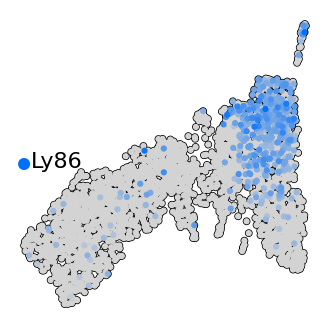

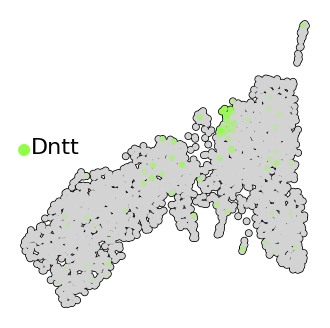

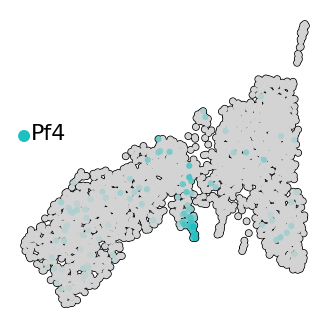

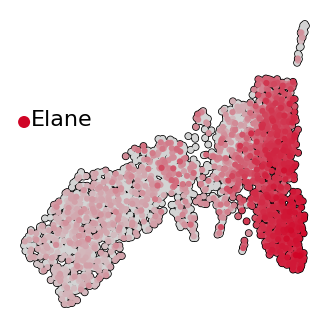

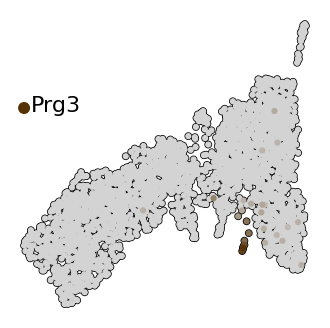

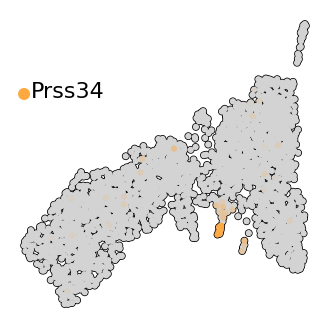

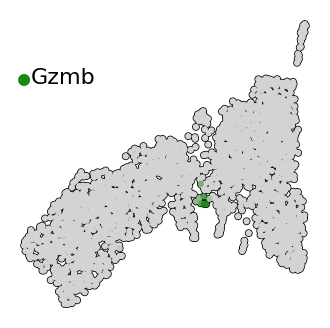

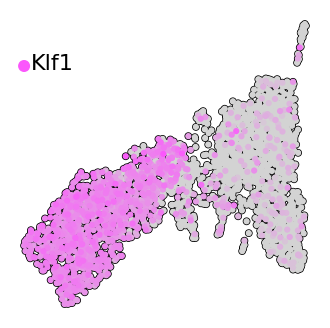

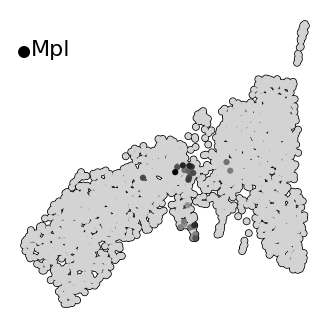

In [51]:
size = 12
zorder = [3,9,2,1,4,8,10,7,100]
#Normalize embedding to unit square:
for i in range(len(cell_types)):
        
    fig, ax = plt.subplots(figsize=(4,4))

    
    cell_type = cell_types[i]
    gene = lineage_associated_genes[cell_type]

    color_list = ['lightgrey', cell_type_colors[cell_type]]
    cmap_lineage = LinearSegmentedColormap.from_list("color_trial", colors=color_list) 

    ax.scatter(embedding_normalized['umap_1'],embedding_normalized['umap_2'], facecolor='none', edgecolor='k',s = 1.75*size,zorder=-1)
    ax.scatter(embedding_normalized['umap_1'],embedding_normalized['umap_2'], facecolor=[0.9,0.9,0.9], edgecolor='none',s = size,zorder=0) 

    annotation_colors = np.concatenate((colors, np.array([[0.1,0.1,0.1]])),axis=0)

    data_z_scores = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names)
    data_z_scores = (data_z_scores - data_z_scores.mean()) / data_z_scores.std()

    gene_exp = data_z_scores[gene_list[i]] 
    plot_order = gene_exp.sort_values(ascending=True).index

    ax.scatter(embedding_normalized.loc[plot_order]['umap_1'],embedding_normalized.loc[plot_order]['umap_2'], s=20, c=gene_exp.loc[plot_order], cmap=cmap_lineage, edgecolor='none')
    ax.scatter(0,0.05*i+0.5, s=75,  facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])
    ax.text(0.025,0.05*i-0.015+0.5, gene_list[i], fontsize=16)

    sbn.despine(left=True, bottom=True)
    plt.xticks([])
    plt.yticks([])

### Initial cells

In [52]:
# Create a new colormap for annotation
color_list = ['lightgrey', 'tomato', 'firebrick', 'darkred']
cmap_gene = LinearSegmentedColormap.from_list("color_trial", colors=color_list) 

We pick coordinates of a representative "initial cell state locus" on the UMAP, lying in a region with high 'Mpl' expression and low 'Pf4' expression.

([], [])

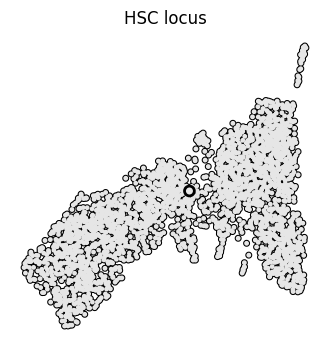

In [53]:
initial_locus = np.array([7.1,-8.1])
plot_order = adata.obs.index[np.argsort(adata[:,'Mpl'].X.toarray().flatten())]

fig, ax = plt.subplots(figsize=(4,4))
size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])

plt.scatter(initial_locus[0],initial_locus[1],s=50,linewidth=2,marker='o', edgecolor='k',facecolor='none',alpha=1) 
plt.title('HSC locus')
sbn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])


Find the nearest cells to this locus on the embedding

In [54]:
n0 = 3
initial_cells = ((embedding - initial_locus)**2).sum(axis=1).sort_values().index[:n0].tolist()

In [55]:
initial_cells

['2727', '1829', '1484']

### Terminal states

Similarly, we choose some representative terminal loci for each lineage:

([], [])

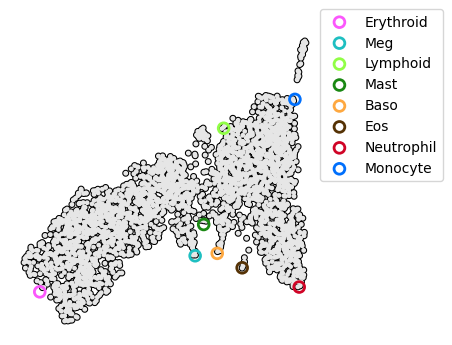

In [56]:
loci = [['Erythroid',  np.array([-3.4,-12.5])], 
        ['Meg',        np.array([7.5,-11])], 
        ['Lymphoid',   np.array([9.5,-5.7])],
        ['Mast',       np.array([8.1,-9.7])],
        ['Baso',       np.array([9.05, -10.9])],
        ['Eos',        np.array([10.8, -11.5])],
        ['Neutrophil', np.array([14.8,-12.3])],
        ['Monocyte',   np.array([14.5,-4.5])]]


fig, ax = plt.subplots(figsize=(4,4)) 

size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])

for locus in loci:

    locus_label = locus[0]
    locus_coordinates_x,locus_coordinates_y = locus[1][0],locus[1][1]
    
    plt.scatter(locus_coordinates_x, locus_coordinates_y, s=5*size, linewidth=2,facecolor='none',color=cell_type_colors[locus_label], label=locus_label)
plt.legend(loc=[1,0.5])

sbn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])

Find cells nearest these points on the UMAP:

In [57]:
terminal_tips = {locus[0] : ((embedding[['umap_1', 'umap_2']] - locus[1])**2).sum(axis=1).sort_values().index[0] for locus in loci}

We pick 3 terminal cells within each lineage:

In [58]:
nFs = {locus[0] : 3 for locus in loci}

In [59]:
terminal_fates = []
terminal_cells = []
embedding_selection_df = embedding.copy()
print("Computing terminals for:")

for label in terminal_tips:
    print(label)
    loci_dists = ((embedding_selection_df - embedding.loc[terminal_tips[label]])**2).sum(axis=1).sort_values()

    indices = loci_dists.index[:nFs[label]].tolist()

    terminal_fates.append(indices)
    terminal_cells += indices
    embedding_selection_df = embedding_selection_df.drop(indices)


Computing terminals for:
Erythroid
Meg
Lymphoid
Mast
Baso
Eos
Neutrophil
Monocyte


In [60]:
fates = {loci[i][0] : terminal_fates[i] for i in range(len(terminal_fates))}
fates

cell_type_color_dict = {cell_types[i] : colors[i] for i in range(len(colors))}

### Visualizing the initial and terminal cells:

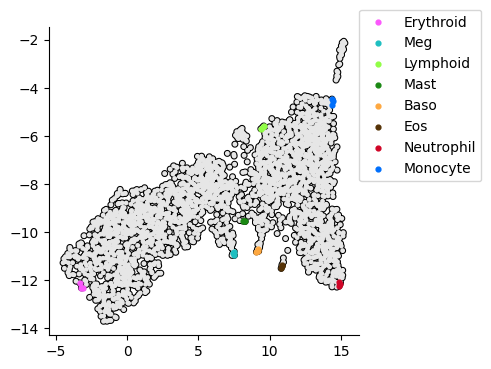

In [61]:
plt.figure(figsize=(4,4)) 

size = 12
plt.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
plt.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])


for i in range(len(terminal_fates)):
    fate  = terminal_fates[i]
    label = loci[i][0]
    plt.scatter(embedding.loc[fate]['umap_1'],embedding.loc[fate]['umap_2'], s=size, color=cell_type_color_dict[label], label=label)
plt.legend(loc=[1,0.5])
sbn.despine()

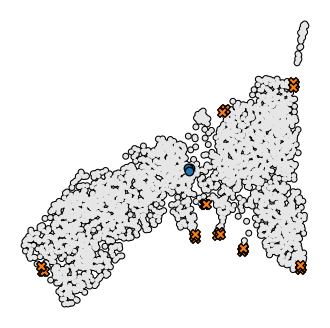

In [62]:
fig, ax = plt.subplots(figsize=(4,4))

size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])


ax.scatter(embedding.loc[initial_cells,'umap_1'], embedding.loc[initial_cells,'umap_2'], s =1.5*25, color = 'tab:blue',  edgecolor='k',label='Initial')
ax.scatter(embedding.loc[terminal_cells, 'umap_1'], embedding.loc[terminal_cells,'umap_2'], s=2*25, color='tab:orange',marker='X', edgecolor='k',label='Terminal')


sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
#plt.legend()

plt.savefig(RESULTS_PATH + 'figures/input_data.png', dpi=600, transparent=True, bbox_inches='tight')

Create markers for initial and terminal states (for manuscript figure)

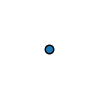

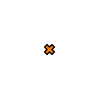

In [63]:
fig, ax = plt.subplots(figsize=(1,1))


ax.scatter(0.5,0.0, s =1.5*25, color = 'tab:blue',  edgecolor='k',label='Initial')

sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.savefig(RESULTS_PATH + 'figures/initial_marker.png', dpi=600, transparent=True, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(1,1))

 
ax.scatter(0.5,0.75, s=2*25, color='tab:orange',marker='X', edgecolor='k',label='Terminal') 


sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.savefig(RESULTS_PATH + 'figures/terminal_marker.png', dpi=600, transparent=True, bbox_inches='tight')

### Apply MultistageOT

We define input data (50 first principal components)

In [64]:
data = adata.obsm['X_pca']
pca_df = pd.DataFrame(data, index=adata.obs.index)

Run MultistageOT algorithm:

In [65]:
msot = MultistageOT(initial_cells   = initial_cells,
                    terminal_cells  = terminal_cells,
                    n_groups        = 20,
                    epsilon         = 0.055
                    )   

msot.fit(pca_df, verbose = True, patience  = 1000, tolerance = 1e-4)

## Perform additional proximal-point updates to reduce epsilon:
msot.proximal_sinkhorn(epsilon_threshold=0.006, patience=1000)

 Iteration: 4000 [========] Max dual step: 3.734e-06 | Infeasibility: 6.496e-05 | Elapsed time: 0:14:48.031308

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 6.496201628558573e-05, 'max_mu_t': 3.6252281086848748e-06, 'mu_T': 6.280158225679955e-07}
 [Proximal Sinkhorn] Outer iterations: 9 | Initial epsilon: 5.5000e-02 | Current epsilon: 5.5000e-02 | Total epsilon: 5.5000e-03 | Elapsed time: 1:10:15.823134
 Terminating proximal scheme.


### Save model

In [66]:
msot.save_model(path = MODEL_PATH + "standard/")

>>> Saving MMOT model...
To:  ../../../../results/real_data/paul2015/saved_models/standard/
Done.


### Load model

In [67]:
msot = MultistageOT()
msot.load_model(path = MODEL_PATH + "standard/")

<<< Loading MMOT model...
From:  ../../../../results/real_data/paul2015/saved_models/standard/
Done.


### Compute cell fate probabilities:

In [68]:
cell_fate_probabilities = msot.cell_fate_probabilities(fates)

### Compute pseudotime:

In [69]:
pseudotime = msot.pseudotemporal_order()

As in the synthetic data set, we graph the predicted cell fate probabilities using pie charts:

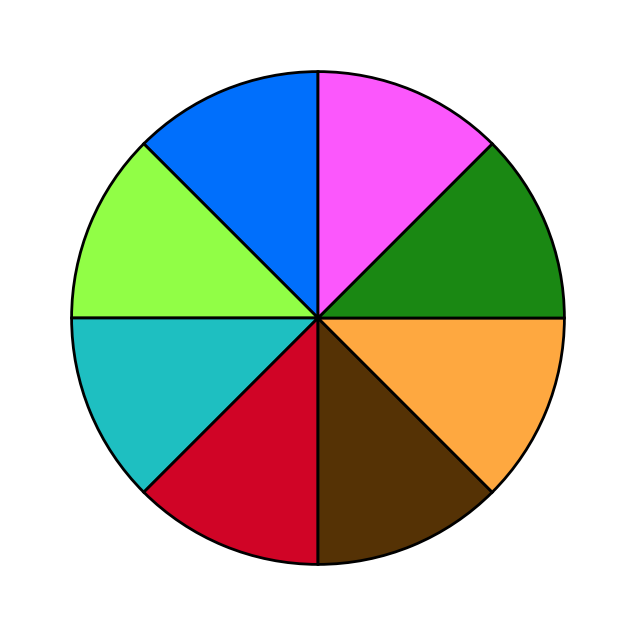

In [70]:
# Plot the pie chart
plt.figure(figsize=(8, 8))

values = np.array([1/cell_fate_probabilities.shape[1] for k in range(cell_fate_probabilities.shape[1])]) 

plt.pie(values, colors=colors,  
        startangle=90, 
        wedgeprops={ 'linewidth' : 2, 'edgecolor' : 'k',  'antialiased': True});

plt.savefig(RESULTS_PATH + "figures/pie_chart.png", transparent=True, dpi=600, bbox_inches='tight')

Visualize cell fate potential over the UMAP:

 Plotting cell nr 2730/2730

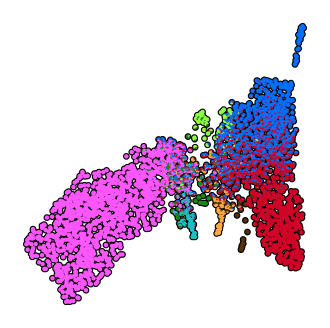

In [71]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4)) 

np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding,
                                cell_fate_probabilities.loc[embedding.index],
                                entropy_fade=False, frac=1, plot_order=cell_types[:-1], colors=colors, s=12, background=11)

# Show the plot
sbn.despine(left=True, bottom=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + 'figures/cell_fate_probabilities.png', dpi=600, transparent=True, bbox_inches='tight')

Zooming in on initial states:

 Plotting cell nr 3/3

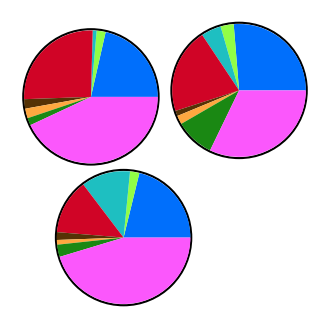

In [72]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4)) 

np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding.loc[initial_cells],
                                cell_fate_probabilities.loc[initial_cells],
                                entropy_fade=False, frac=1, indices=initial_cells, plot_order=cell_types[:-1], colors=colors, s=38000, background=9500)

# Show the plot
sbn.despine(left=True, bottom=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + 'figures/cell_fate_probabilities_initial_cells.png', dpi=600, transparent=True, bbox_inches='tight')

### Pseudotemporal ordering

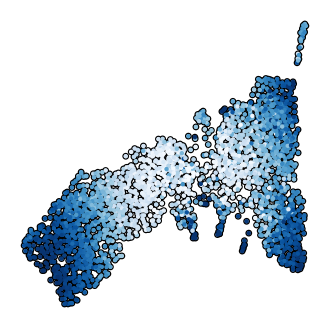

In [73]:
fig, ax = plt.subplots(figsize=(4,4))
pt_order = msot.pseudotemporal_order()
plt.scatter(adata[pt_order.index].obsm['X_umap'][:,0],adata[pt_order.index].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
plt.scatter(adata[pt_order.index].obsm['X_umap'][:,0],adata[pt_order.index].obsm['X_umap'][:,1],s=10, edgecolor='none',c=pt_order, cmap='Blues')

sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + 'figures/pseudotime.png', dpi=600, transparent=True, bbox_inches='tight')

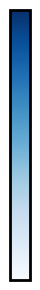

In [74]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_outliers = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues', 
                                orientation='vertical')
cb_outliers.set_ticks([])
cb_outliers.outline.set_linewidth(2)
 
 
cb_outliers.set_ticklabels([])
plt.savefig(RESULTS_PATH + 'figures/pseudotime_colorbar.png', transparent=True,dpi=600,bbox_inches='tight')
plt.show()

### Repeat with a different number of cells in the Erythroid lineage

In [75]:
embedding = pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index,columns=['umap_1','umap_2'])

We create two new loci for the Erythroid fate

([], [])

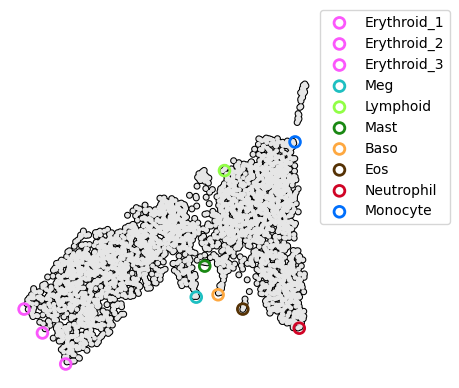

In [76]:
loci = [['Erythroid_1',  np.array([-3.4,-12.5])], 
        ['Erythroid_2',  np.array([-1.75,-13.8])],
        ['Erythroid_3',  np.array([-4.7,-11.5])],
        ['Meg',        np.array([7.5,-11])], 
        ['Lymphoid',   np.array([9.5,-5.7])],
        ['Mast',       np.array([8.1,-9.7])],
        ['Baso',       np.array([9.05, -10.9])],
        ['Eos',        np.array([10.8, -11.5])],
        ['Neutrophil', np.array([14.8,-12.3])],
        ['Monocyte',   np.array([14.5,-4.5])]]


fig, ax = plt.subplots(figsize=(4,4)) 

size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])

for locus in loci:

        locus_label = locus[0]
        locus_coordinates_x,locus_coordinates_y = locus[1][0],locus[1][1]
        if 'Erythroid' in locus_label:
                plt.scatter(locus_coordinates_x, locus_coordinates_y, s=5*size, linewidth=2,facecolor='none',color=cell_type_colors['Erythroid'], label=locus_label)
        else:
                plt.scatter(locus_coordinates_x, locus_coordinates_y, s=5*size, linewidth=2,facecolor='none',color=cell_type_colors[locus_label], label=locus_label)

plt.legend(loc=[1,0.5])

sbn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])

In [77]:
terminal_tips = {locus[0] : ((embedding[['umap_1', 'umap_2']] - locus[1])**2).sum(axis=1).sort_values().index[0] for locus in loci}

The erythroid lineages get a total of 30 terminal cells, 10x the cells in the number of cells in other lineages

In [117]:
nFs = {locus[0] : 3 for locus in loci}

nFs['Erythroid_1'] = 10
nFs['Erythroid_2'] = 10
nFs['Erythroid_3'] = 10

In [118]:
terminal_fates = []
terminal_cells = []
embedding_selection_df = embedding.copy()
print("Computing terminals for:")

for label in terminal_tips:
    print(label)
    loci_dists = ((embedding_selection_df - embedding.loc[terminal_tips[label]])**2).sum(axis=1).sort_values()

    indices = loci_dists.index[:nFs[label]].tolist()

    terminal_fates.append(indices)
    terminal_cells += indices
    embedding_selection_df = embedding_selection_df.drop(indices)


Computing terminals for:
Erythroid_1
Erythroid_2
Erythroid_3
Meg
Lymphoid
Mast
Baso
Eos
Neutrophil
Monocyte


### Visualizing new initial and terminal states

[]

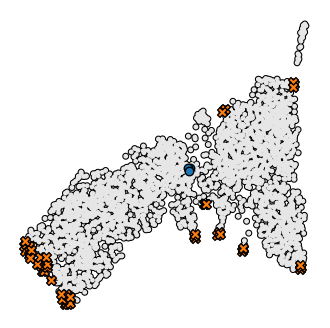

In [119]:
fig, ax = plt.subplots(figsize=(4,4))

size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])


ax.scatter(embedding.loc[initial_cells,'umap_1'], embedding.loc[initial_cells,'umap_2'], s =1.5*25, color = 'tab:blue',  edgecolor='k',label='Initial')
ax.scatter(embedding.loc[terminal_cells, 'umap_1'], embedding.loc[terminal_cells,'umap_2'], s=2*25, color='tab:orange',marker='X', edgecolor='k',label='Terminal')


sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])


In [120]:
msot_ery = MultistageOT(initial_cells  = initial_cells,
                        terminal_cells = terminal_cells,
                        n_groups       = 20,
                        epsilon        = 0.055
                        )

msot_ery.fit(pca_df, verbose = True, patience  = 1000, tolerance = 1e-4)

## Perform additional proximal-point updates to reduce epsilon:
msot_ery.proximal_sinkhorn(epsilon_threshold=0.006, patience=1000)

 Iteration: 4000 [========] Max dual step: 4.601e-06 | Infeasibility: 8.024e-05 | Elapsed time: 0:10:04.422178

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 8.024350091406784e-05, 'max_mu_t': 4.462163488816451e-06, 'mu_T': 7.424255682453307e-07}
 [Proximal Sinkhorn] Outer iterations: 9 | Initial epsilon: 5.5000e-02 | Current epsilon: 5.5000e-02 | Total epsilon: 5.5000e-03 | Elapsed time: 0:39:07.467735
 Terminating proximal scheme.


### Save model

In [121]:
msot_ery.save_model(path = MODEL_PATH + "more_erythroid/")

>>> Saving MMOT model...
To:  ../../../../results/real_data/paul2015/saved_models/more_erythroid/
Done.


### Load model

In [122]:
msot_ery = MultistageOT()
msot_ery.load_model(path = MODEL_PATH + "more_erythroid/")

<<< Loading MMOT model...
From:  ../../../../results/real_data/paul2015/saved_models/more_erythroid/
Done.


Update fate and color dictionaries

In [123]:
fates = {loci[i][0] : terminal_fates[i] for i in range(len(terminal_fates))}

#Aggregate the terminal cells in the Erythroid lineage:
fates['Erythroid'] = fates['Erythroid_1'] + fates['Erythroid_2'] + fates['Erythroid_3']
fates.pop('Erythroid_1')
fates.pop('Erythroid_2')
fates.pop('Erythroid_3')
cell_type_color_dict = {cell_types[i] : colors[i] for i in range(len(colors[:-1]))}

### Cell fate probabilities

In [124]:
cell_fate_probabilities_many_ery = msot_ery.cell_fate_probabilities(fates)

 Plotting cell nr 2730/2730

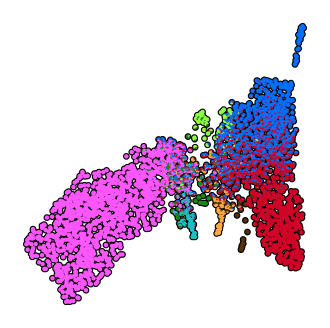

In [125]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4)) 

np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding,
                                cell_fate_probabilities.loc[embedding.index],
                                entropy_fade=False, frac=1, plot_order=cell_types[:-1], colors=colors[:-1], s=12, background=11)

# Show the plot
sbn.despine(left=True, bottom=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + 'figures/cell_fate_probabilities_many_ery.png', dpi=600, transparent=True, bbox_inches='tight')

([], [])

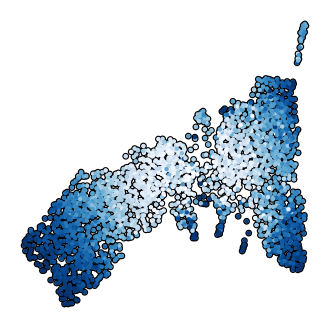

In [126]:
fig, ax = plt.subplots(figsize=(4,4))
pseudotime_many_ery = msot_ery.pseudotemporal_order()
plt.scatter(adata[pseudotime_many_ery.index].obsm['X_umap'][:,0],adata[pseudotime_many_ery.index].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
plt.scatter(adata[pseudotime_many_ery.index].obsm['X_umap'][:,0],adata[pseudotime_many_ery.index].obsm['X_umap'][:,1],s=10, edgecolor='none',c=pseudotime_many_ery, cmap='Blues')

sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])


 Plotting cell nr 3/3

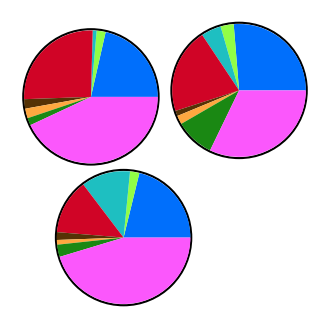

In [127]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4)) 

np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding.loc[initial_cells],
                                cell_fate_probabilities.loc[initial_cells],
                                entropy_fade=False, frac=1, indices=initial_cells, plot_order=cell_types[:-1], colors=colors, s=38000, background=9500)

# Show the plot
sbn.despine(left=True, bottom=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + 'figures/cell_fate_probabilities_initial_cells_many_ery.png', dpi=600, transparent=True, bbox_inches='tight')

Conclusion: solution is not identical but similar to the case where there were 3, as opposed to 30, cells in the Erythroid fate.

### Quantifying the difference in downstream results

In [128]:
TV = (0.5*(cell_fate_probabilities - cell_fate_probabilities_many_ery).abs().sum(axis=1))

In [129]:
print("TV (+- std. error): {tv} +- {sem}".format(tv=TV.mean(), sem=TV.std()/np.sqrt(TV.shape[0])))

TV (+- std. error): 0.021752712016877222 +- 0.001064997533569511


In [130]:
cell_fate_probabilities.shape

(2730, 8)

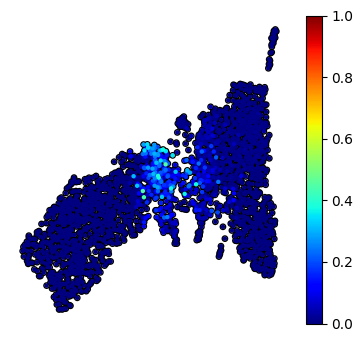

In [131]:
fig, ax = plt.subplots(figsize=(4.5,4))
plot_order = TV.sort_values().index
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=10, edgecolor='none',c=TV.loc[plot_order], vmax=1, cmap='jet')

sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [132]:
pt_error = (pseudotime - pseudotime_many_ery).abs()

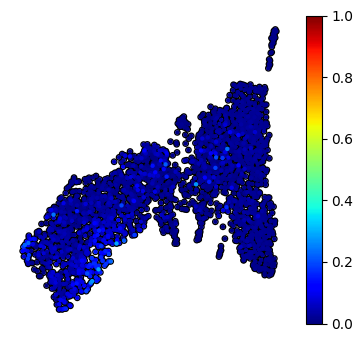

In [135]:
fig, ax = plt.subplots(figsize=(4.5,4))
plot_order = pt_error.sort_values().index
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=10, edgecolor='none',c=pt_error.loc[plot_order].values, cmap='jet', vmax=1)

sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])
plt.colorbar()

### 10 and 30 differentiation stages (instead of 20)

In [136]:
loci = [['Erythroid',  np.array([-3.4,-12.5])], 
        ['Meg',        np.array([7.5,-11])], 
        ['Lymphoid',   np.array([9.5,-5.7])],
        ['Mast',       np.array([8.1,-9.7])],
        ['Baso',       np.array([9.05, -10.9])],
        ['Eos',        np.array([10.8, -11.5])],
        ['Neutrophil', np.array([14.8,-12.3])],
        ['Monocyte',   np.array([14.5,-4.5])]]

In [137]:
terminal_tips = {locus[0] : ((embedding[['umap_1', 'umap_2']] - locus[1])**2).sum(axis=1).sort_values().index[0] for locus in loci}

In [138]:
nFs = {locus[0] : 3 for locus in loci}

In [139]:
terminal_fates = []
terminal_cells = []
embedding_selection_df = embedding.copy()
print("Computing terminals for:")

for label in terminal_tips:
    print(label)
    loci_dists = ((embedding_selection_df - embedding.loc[terminal_tips[label]])**2).sum(axis=1).sort_values()

    indices = loci_dists.index[:nFs[label]].tolist()

    terminal_fates.append(indices)
    terminal_cells += indices
    embedding_selection_df = embedding_selection_df.drop(indices)


Computing terminals for:
Erythroid
Meg
Lymphoid
Mast
Baso
Eos
Neutrophil
Monocyte


[]

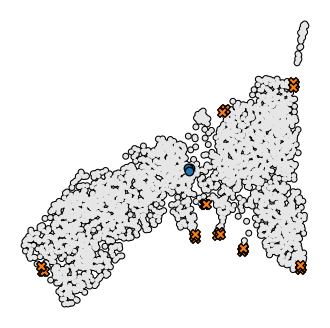

In [140]:
fig, ax = plt.subplots(figsize=(4,4))

size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])


ax.scatter(embedding.loc[initial_cells,'umap_1'], embedding.loc[initial_cells,'umap_2'], s =1.5*25, color = 'tab:blue',  edgecolor='k',label='Initial')
ax.scatter(embedding.loc[terminal_cells, 'umap_1'], embedding.loc[terminal_cells,'umap_2'], s=2*25, color='tab:orange',marker='X', edgecolor='k',label='Terminal')


sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
#plt.legend() 

In [141]:
fates = {loci[i][0] : terminal_fates[i] for i in range(len(terminal_fates))}

cell_type_color_dict = {cell_types[i] : colors[i] for i in range(len(colors))}

In [144]:
cell_fate_probabilities_list = []
pseudotime_list = []
stages_to_run = [10,30]
for n_stages in stages_to_run:
    msot_experiment = MultistageOT(initial_cells   = initial_cells,
                                   terminal_cells  = terminal_cells,
                                   n_groups        = n_stages,
                                   epsilon         = 0.055
                                    )

    msot_experiment.fit(pca_df, verbose = True, patience  = 1000, tolerance = 1e-4)

    ## Perform additional proximal-point updates to reduce epsilon:
    msot_experiment.proximal_sinkhorn(epsilon_threshold=0.006, patience=1000)

    cell_fate_probabilities_list.append(msot_experiment.cell_fate_probabilities(fates))
    pseudotime_list.append(msot_experiment.pseudotemporal_order())
    
    msot_experiment.save_model(path = MODEL_PATH + "{stages}_stages/".format(stages=n_stages))

 Iteration: 6000 [========] Max dual step: 3.074e-07 | Infeasibility: 5.473e-06 | Elapsed time: 0:05:56.144040

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 5.4733712138155255e-06, 'max_mu_t': 1.0883083151891348e-06, 'mu_T': 3.576925888815197e-08}
 [Proximal Sinkhorn] Outer iterations: 9 | Initial epsilon: 5.5000e-02 | Current epsilon: 5.5000e-02 | Total epsilon: 5.5000e-03 | Elapsed time: 0:12:43.305109
 Terminating proximal scheme.
>>> Saving MMOT model...
To:  ../../../../results/real_data/paul2015/saved_models/10_stages/
Done.
 Iteration: 11000 [========] Max dual step: 4.177e-06 | Infeasibility: 7.526e-05 | Elapsed time: 0:22:33.539824

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibil

We can now investigate how much the downstream results deviate from the original results that used 20 stages:

TV (+- std. error): 0.09014873426503066 +- 0.0026954055411494374
TV (+- std. error): 0.05464685333352975 +- 0.001568304842186023


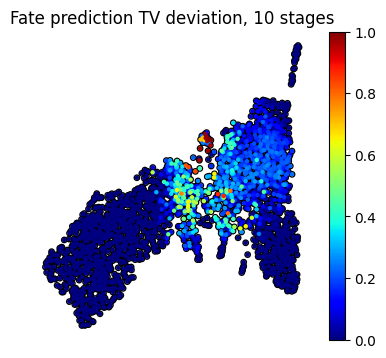

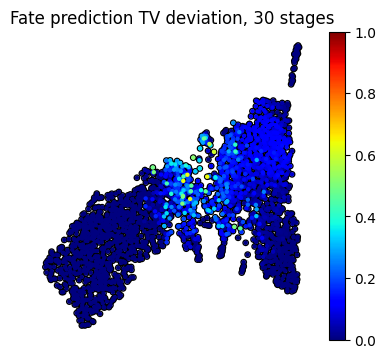

In [159]:
for i in range(len(cell_fate_probabilities_list)):
    TV = (0.5*(cell_fate_probabilities - cell_fate_probabilities_list[i][cell_fate_probabilities.columns]).abs().sum(axis=1))

    print("TV (+- std. error): {tv} +- {sem}".format(tv=TV.mean(), sem=TV.std()/np.sqrt(TV.shape[0])))

    fig, ax = plt.subplots(figsize=(4.5,4))
    plot_order = TV.sort_values().index
    plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
    plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=10, edgecolor='none',c=TV.loc[plot_order], cmap='jet', vmax=1)

    sbn.despine(left=True,bottom=True)
    plt.xticks([])
    plt.yticks([])
    plt.title("Fate prediction TV deviation, " + str(stages_to_run[i]) + " stages")
    plt.colorbar()

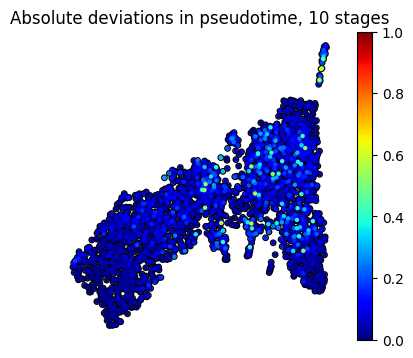

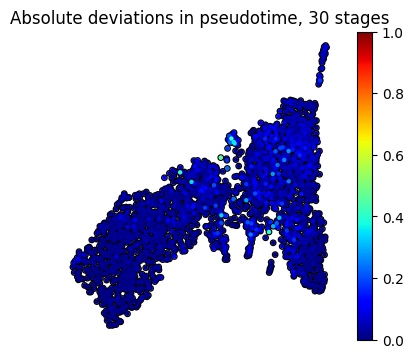

In [160]:
for i in range(len(stages_to_run)):
    fig, ax = plt.subplots(figsize=(4.5,4))

    pt_error = (pseudotime - pseudotime_list[i]).abs()
    plot_order = pt_error.sort_values().index
    plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
    plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=10, edgecolor='none',c=pt_error.loc[plot_order].values, cmap='jet', vmax=1)

    sbn.despine(left=True,bottom=True)
    plt.xticks([])
    plt.yticks([])
    plt.title("Absolute deviations in pseudotime, " + str(stages_to_run[i]) + " stages")
    plt.colorbar()